# Introduction
The objective of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task.

* **Supervised**: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* **Classification**: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

# Manual Setting

In [1]:
BaselineTraining = True
LogisticRegression = True
RandomForest = True

PolynomialFeaturesTesting = True
DomainFeaturesTesting = True

# Load In Data

## Training and Testing

In [2]:
import pandas as pd
import os, sys
import gc

default_dir = ""

app_train = pd.read_csv(os.path.join(default_dir,'application_train.csv'))
app_test = pd.read_csv(os.path.join(default_dir,'application_test.csv'))

print(f'Training Data Shape: {app_train.shape}')
print(f'Testing Data Shape: {app_test.shape}')

app_test.head()  


Training Data Shape: (307511, 122)
Testing Data Shape: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Reduce Memory Allotted Size

POS_CASH_balance, installments_payments, credit_card_balance

In [3]:
import numpy as np

def get_balance_data():
    pos_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int32, 'SK_DPD':np.int32,
        'SK_DPD_DEF':np.int32, 'CNT_INSTALMENT':np.float32,'CNT_INSTALMENT_FUTURE':np.float32
    }

    install_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'NUM_INSTALMENT_NUMBER':np.int32, 'NUM_INSTALMENT_VERSION':np.float32,
        'DAYS_INSTALMENT':np.float32, 'DAYS_ENTRY_PAYMENT':np.float32, 'AMT_INSTALMENT':np.float32, 'AMT_PAYMENT':np.float32
    }

    card_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int16,
        'AMT_CREDIT_LIMIT_ACTUAL':np.int32, 'CNT_DRAWINGS_CURRENT':np.int32, 'SK_DPD':np.int32,'SK_DPD_DEF':np.int32,
        'AMT_BALANCE':np.float32, 'AMT_DRAWINGS_ATM_CURRENT':np.float32, 'AMT_DRAWINGS_CURRENT':np.float32,
        'AMT_DRAWINGS_OTHER_CURRENT':np.float32, 'AMT_DRAWINGS_POS_CURRENT':np.float32, 'AMT_INST_MIN_REGULARITY':np.float32,
        'AMT_PAYMENT_CURRENT':np.float32, 'AMT_PAYMENT_TOTAL_CURRENT':np.float32, 'AMT_RECEIVABLE_PRINCIPAL':np.float32,
        'AMT_RECIVABLE':np.float32, 'AMT_TOTAL_RECEIVABLE':np.float32, 'CNT_DRAWINGS_ATM_CURRENT':np.float32,
        'CNT_DRAWINGS_OTHER_CURRENT':np.float32, 'CNT_DRAWINGS_POS_CURRENT':np.float32, 'CNT_INSTALMENT_MATURE_CUM':np.float32
    }

    pos_bal = pd.read_csv(os.path.join(default_dir,'POS_CASH_balance.csv'), dtype=pos_dtype)
    install = pd.read_csv(os.path.join(default_dir,'installments_payments.csv'), dtype=install_dtype)
    card_bal = pd.read_csv(os.path.join(default_dir, 'credit_card_balance.csv'), dtype=card_dtype)

    return pos_bal, install, card_bal

pos_bal, install, card_bal = get_balance_data()

# EDA

## Data Imbalanced

<Axes: ylabel='Frequency'>

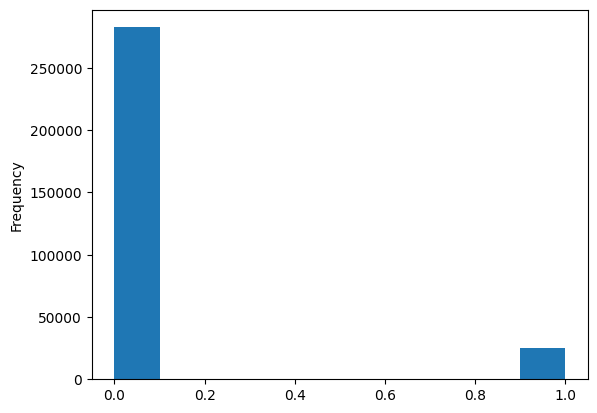

In [4]:
# app_train['TARGET'].value_counts()
app_train['TARGET'].astype(int).plot.hist()

## Missing Values

In [5]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can [handle missing values with no need for imputation.](https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase) Another option would be to drop columns with a high percentage of missing values.

## Column Types

In [8]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

## Unique Entries
of the `object`(categorical) columns.

In [9]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables!

### Encoding Categorical Variables

For categorical variables with many classes, one-hot encoding is the safest approach because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categories. 

Let's implement the policy described above: for any categorical variable (`dtype == object`) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

#### Label Encoding

In [10]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


#### One-Hot Encoding

In [11]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data.

* Only column labels that are present in both df1 and df2 are retained [(join='inner').](https://stackoverflow.com/questions/51645195/pandas-align-function-illustrative-example/51645550)

In [12]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


## Anomalies

Mis-typed numbers, errors in measuring equipment, or extreme measurements.

In [13]:
# (app_train['DAYS_BIRTH'] / -365).describe()
(app_train['DAYS_EMPLOYED'] / -365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

10       365243
17       365243
22       365243
26       365243
36       365243
          ...  
48717    365243
48728    365243
48731    365243
48735    365243
48736    365243
Name: DAYS_EMPLOYED, Length: 9274, dtype: int64

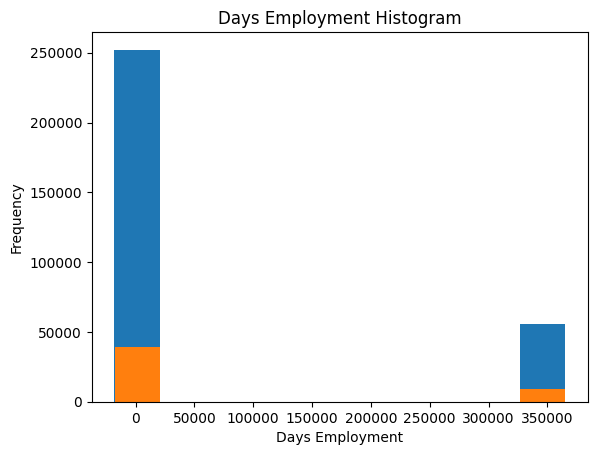

In [14]:
import matplotlib.pyplot as plt

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
app_test['DAYS_EMPLOYED'].plot.hist()
plt.xlabel('Days Employment')

app_test['DAYS_EMPLOYED'][app_test['DAYS_EMPLOYED'] > 200000]

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [15]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default. We will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

There are 9274 anomalies in the test data out of 48744 entries



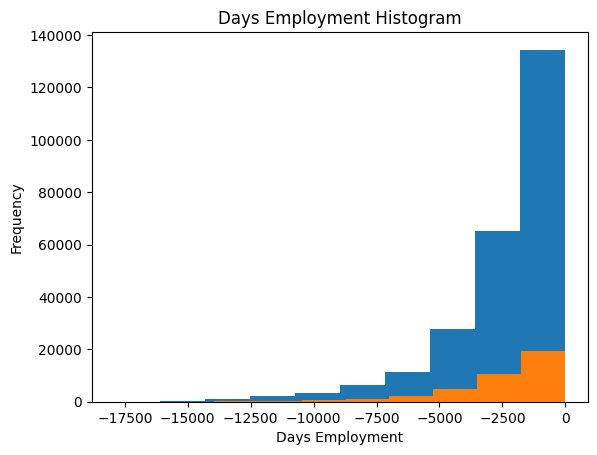

In [16]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
app_test['DAYS_EMPLOYED'].plot.hist()
plt.xlabel('Days Employment')

print('There are %d anomalies in the test data out of %d entries\n' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

## Correlations

In [17]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

### Effect of Age on Repayment

In [18]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830984513

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

#### Distribution of Age

Text(0, 0.5, 'Count')

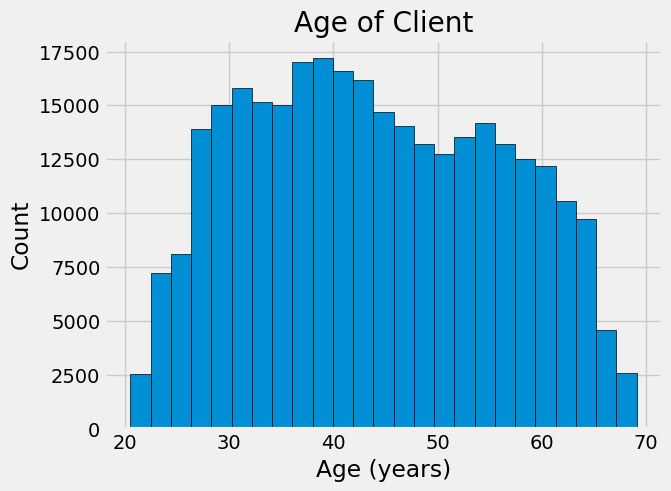

In [19]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')

#### Visualize The Effect of The Age on The Target

C:\Users\carka\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\carka\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of Ages')

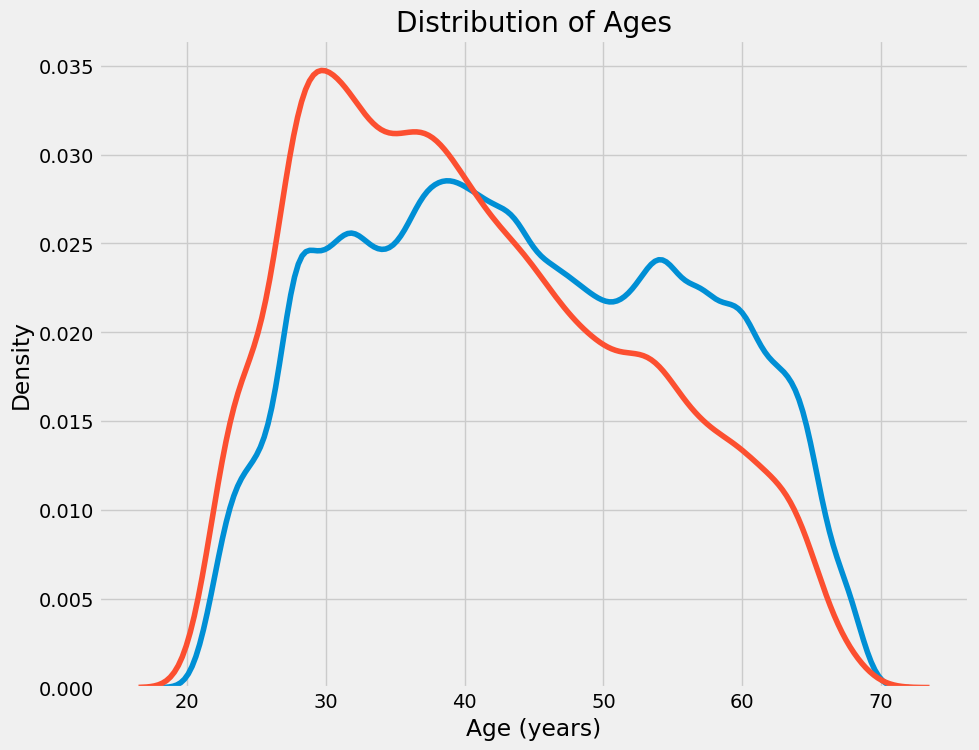

In [20]:
import seaborn as sns

plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [21]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

C:\Users\carka\AppData\Local\Temp\ipykernel_17976\1136001900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
C:\Users\carka\AppData\Local\Temp\ipykernel_17976\1136001900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [22]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

C:\Users\carka\AppData\Local\Temp\ipykernel_17976\1757995694.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_groups  = age_data.groupby('YEARS_BINNED').mean()


,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, 'Failure to Repay by Age Group')

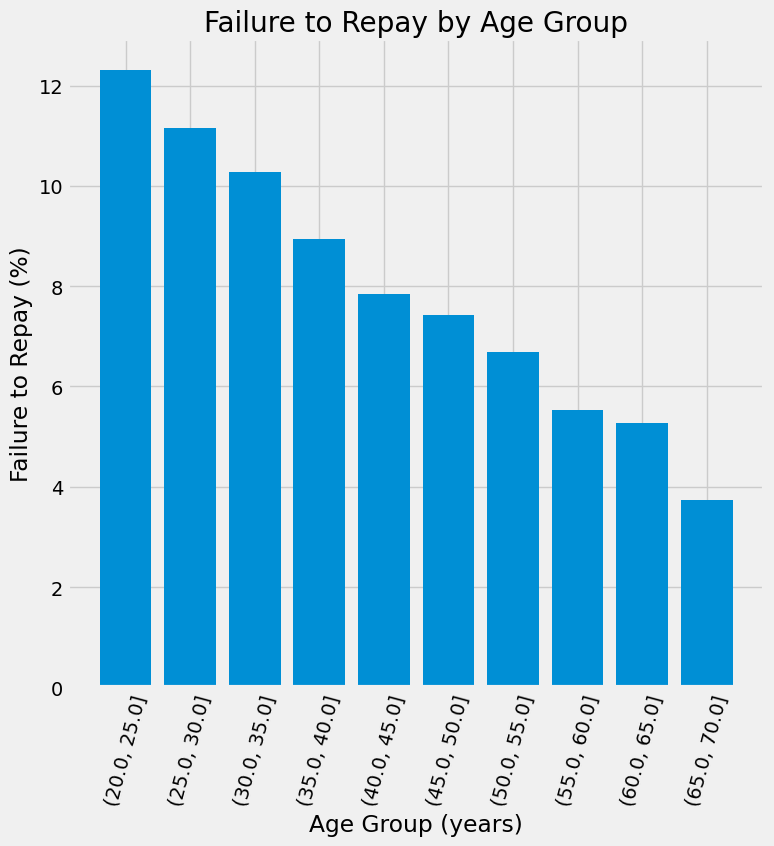

In [23]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.

In [24]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

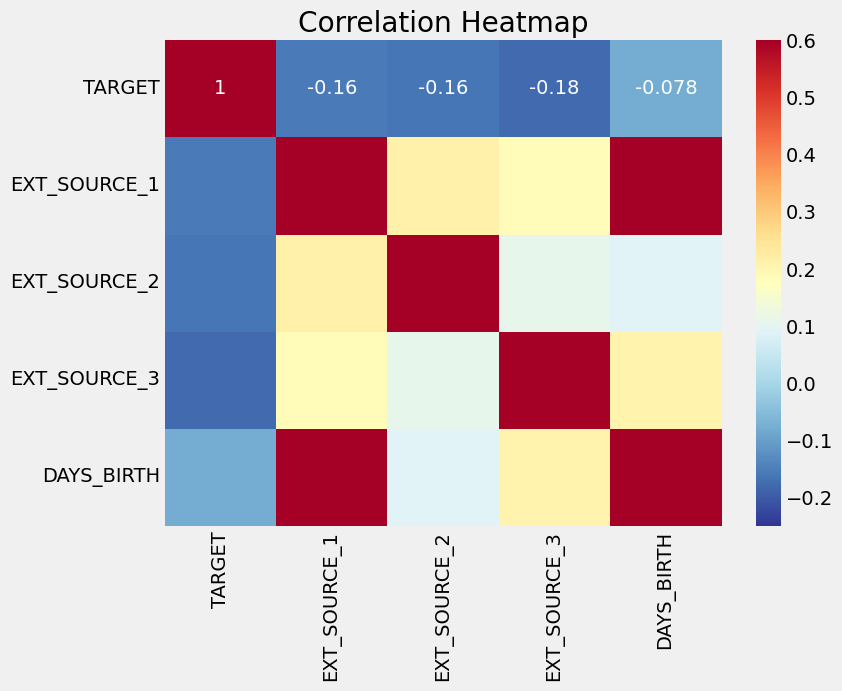

In [25]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

All three `EXT_SOURCE` featureshave negative correlations with the target, indicating that as the value of the `EXT_SOURCE` increases, the client is more likely to repay the loan. We can also see that `DAYS_BIRTH` is positively correlated with `EXT_SOURCE_1` indicating that maybe one of the factors in this score is the client age.

C:\Users\carka\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\carka\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\carka\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\carka\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

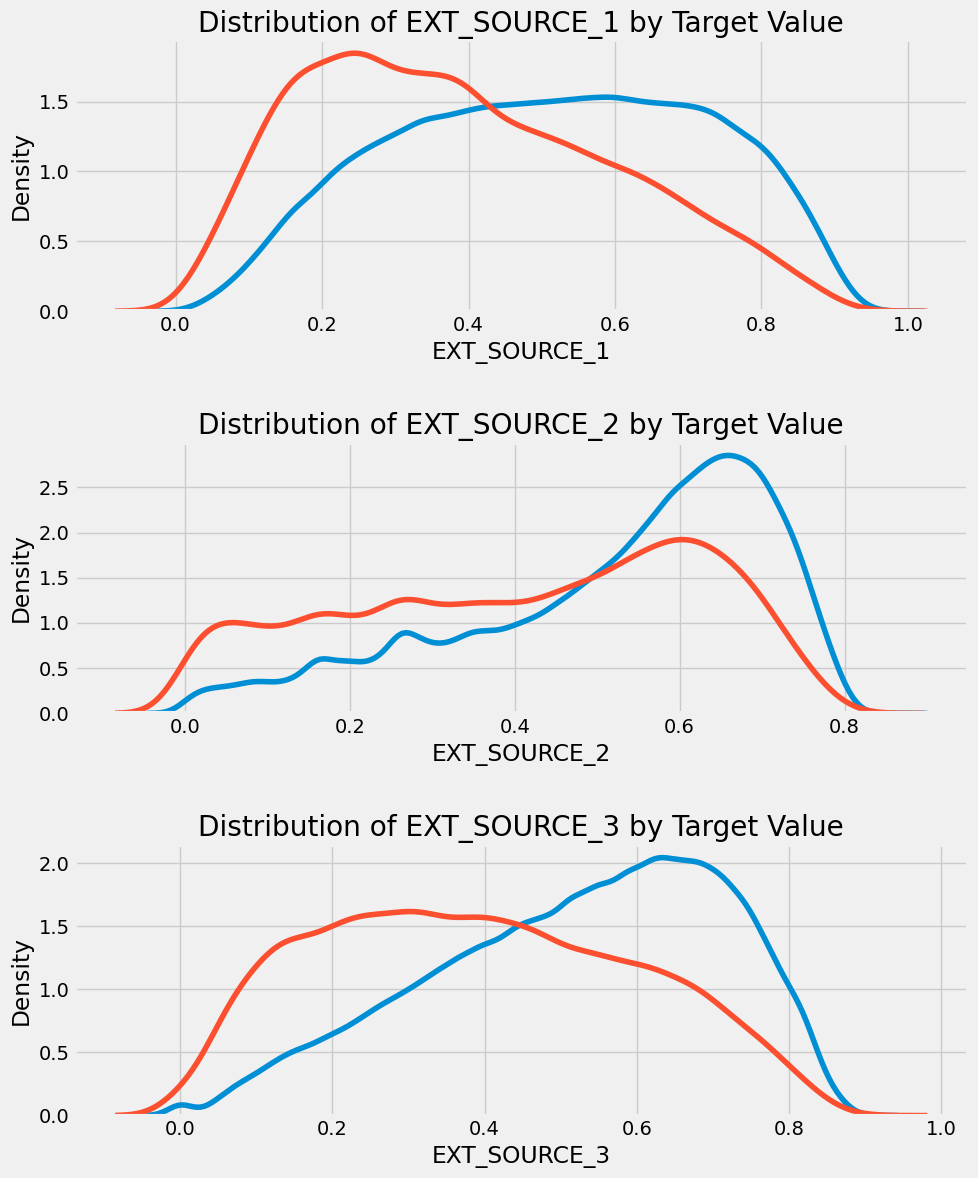

In [26]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

# Feature Engineering (Example)

Kaggle competitions are won by feature engineering: those win are those who can create the most useful features out of the data. This represents one of the patterns in machine learning: **Feature engineering has a greater return on investment than model building and hyperparameter tuning.** As Andrew Ng is fond of saying: **Applied machine learning is basically feature engineering.**

## Polynomial Features

Dealing with [ImportError](https://stackoverflow.com/questions/59439096/importerror-cannnot-import-name-imputer-from-sklearn-preprocessing): `cannot import name 'Imputer' from 'sklearn.preprocessing'`: <br>
It has been deprecated with **scikit-learn v0.20.4** and removed as of **v0.22.2**.

In [27]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
# from sklearn.preprocessing import Imputer
# imputer = Imputer(strategy = 'median')
# cannot import name 'Imputer' from 'sklearn.preprocessing'
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [28]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


This creates a considerable number of new features. To get the names we have to use the polynomial features `get_feature_names` method.

In [29]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [30]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                         'EXT_SOURCE_3', 'DAYS_BIRTH']))
# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.194235
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189593
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181417
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176589
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.171729
EXT_SOURCE_1 EXT_SOURCE_2                -0.166538
EXT_SOURCE_1 EXT_SOURCE_3                -0.164933
EXT_SOURCE_2                             -0.160303
EXT_SOURCE_3                             -0.157397
EXT_SOURCE_2 DAYS_BIRTH                  -0.156879
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


We will add these features to a copy of the training and testing data and then evaluate models with and without the features. The only way to know if an approach will work is to try it out!

In [31]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


## Domain Knowledge Features

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`: the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

C:\Users\carka\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\carka\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\carka\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\carka\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

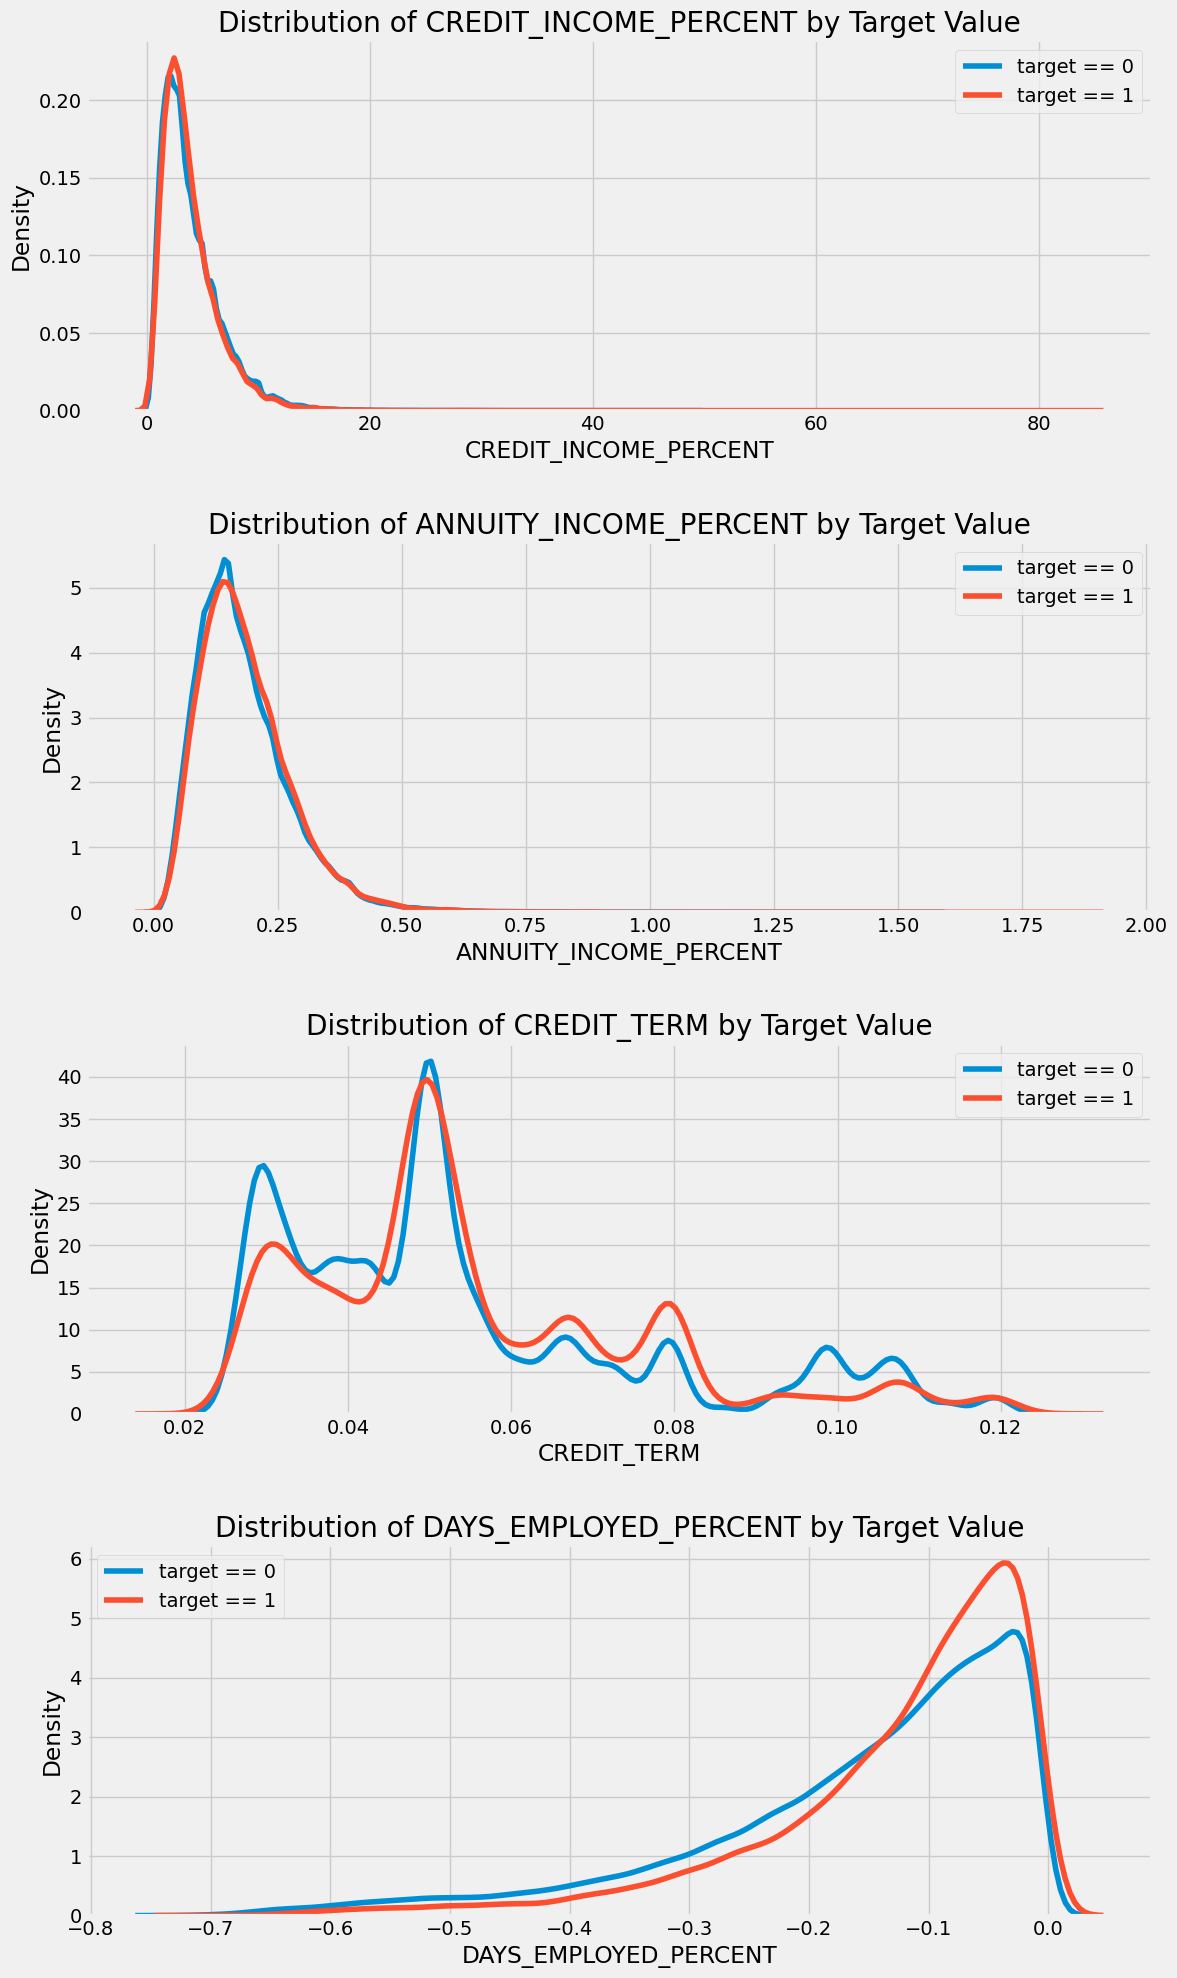

In [32]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # matplotlib.pyplot.legend
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    plt.legend()
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

# Feature Engineering (Final)

In [33]:
def get_apps_processed(apps):
    """
    feature engineering for apps
    """

    # 1.EXT_SOURCE_X FEATURE 
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

In [34]:
def get_prev_processed(prev):
    """
    feature engineering 
    for previouse application credit history
    """
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']

    # Data Cleansing
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

    # substraction between DAYS_LAST_DUE_1ST_VERSION and DAYS_LAST_DUE
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

    # 1.Calculate the interest rate
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    return prev

def get_prev_amt_agg(prev):
    """
    feature engineering for the previous credit appliction
    """

    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
        
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index 
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]

    return prev_amt_agg

def get_prev_refused_appr_agg(prev):
    """
    PREV_APPROVED_COUNT : Credit application approved count
    PREV_REFUSED_COUNT :  Credit application refused count
    """
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    # unstack() 
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()

    # rename column 
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]

    # NaN
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)

    return prev_refused_appr_agg

# DAYS_DECISION
def get_prev_days365_agg(prev):
    """
    DAYS_DESCISION means How many days have been take since the previous credit application made.
    Somehow this feature is important.
    """
    cond_days365 = prev['DAYS_DECISION'] > -365
    prev_days365_group = prev[cond_days365].groupby('SK_ID_CURR')
    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_days365_agg = prev_days365_group.agg(agg_dict)

    # multi index 
    prev_days365_agg.columns = ["PREV_D365_"+ "_".join(x).upper() for x in prev_days365_agg.columns.ravel()]

    return prev_days365_agg

def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    prev_days365_agg = get_prev_days365_agg(prev)
    
    # prev_amt_agg
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    prev_agg = prev_agg.merge(prev_days365_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR APPROVED_COUNT REFUSED_COUNT
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

In [35]:
def get_bureau_processed(bureau):
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
  
    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    #bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']
    
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)
    
    return bureau

def get_bureau_day_amt_agg(bureau):
    bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],

    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_grp = bureau.groupby('SK_ID_CURR')
    bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
    bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
    # SK_ID_CURR reset_index()
    bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
    #print('bureau_day_amt_agg shape:', bureau_day_amt_agg.shape)
    return bureau_day_amt_agg

def get_bureau_active_agg(bureau):
    '''
    Bureau CREDIT_ACTIVE='Active' filtering
    SK_ID_CURR aggregation
    '''
    # CREDIT_ACTIVE='Active' filtering
    cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
    bureau_active_grp = bureau[cond_active].groupby(['SK_ID_CURR'])
    bureau_agg_dict = {
      'SK_ID_BUREAU':['count'],
      'DAYS_CREDIT':['min', 'max', 'mean'],
      'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
      'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
      'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
      'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
      'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
      'AMT_ANNUITY': ['max', 'mean', 'sum'],

      'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
      'BUREAU_IS_DPD':['mean', 'sum'],
      'BUREAU_IS_DPD_OVER120':['mean', 'sum']
      }

    bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
    bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
    # SK_ID_CURR reset_index() 
    bureau_active_agg = bureau_active_agg.reset_index()
    #print('bureau_active_agg shape:', bureau_active_agg.shape)
    return bureau_active_agg

# BUREAU DAYS_CREDIT -750
def get_bureau_days750_agg(bureau):
    cond_days750 = bureau['DAYS_CREDIT'] > -750
    bureau_days750_group = bureau[cond_days750].groupby('SK_ID_CURR')
    bureau_agg_dict = {
        'SK_ID_BUREAU':['count'],
        'DAYS_CREDIT':['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        
        'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
        'BUREAU_IS_DPD':['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120':['mean', 'sum']
        }

    bureau_days750_agg = bureau_days750_group.agg(bureau_agg_dict)
    bureau_days750_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_days750_agg.columns.ravel()]
    bureau_days750_agg = bureau_days750_agg.reset_index()
    
    return bureau_days750_agg

# bureau_bal SK_ID_CURR MONTHS_BALANCE aggregation
def get_bureau_bal_agg(bureau, bureau_bal):
    # SK_ID_CURR Group by bureau SK_ID_CURR 
    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
    
    # STATUS 120
    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)
    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')
    # SK_ID_CURR MONTHS_BALANCE aggregation
    bureau_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'max', 'mean'],
        'BUREAU_BAL_IS_DPD':['mean', 'sum'],
        'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]
    # SK_ID_CURR reset_index()
    bureau_bal_agg = bureau_bal_agg.reset_index()
    #print('bureau_bal_agg shape:', bureau_bal_agg.shape)
    return bureau_bal_agg

# bureau aggregation
def get_bureau_agg(bureau, bureau_bal):
    
    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_days750_agg = get_bureau_days750_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)
    
    # bureau_day_amt_agg bureau_active_agg
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    # STATUS ACTIVE IS_DPD RATIO
    #bureau_agg['BUREAU_IS_DPD_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    #bureau_agg['BUREAU_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    
    # bureau_agg bureau_bal_agg
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    bureau_agg = bureau_agg.merge(bureau_days750_agg, on='SK_ID_CURR', how='left') 
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_OVER120_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']

    #print('bureau_agg shape:', bureau_agg.shape)
    
    return bureau_agg

In [36]:
def get_pos_bal_agg(pos_bal):
    # (SK_DPD) 0 , 0~ 100 , 100
    cond_over_0 = pos_bal['SK_DPD'] > 0
    cond_100 = (pos_bal['SK_DPD'] < 100) & (pos_bal['SK_DPD'] > 0)
    cond_over_100 = (pos_bal['SK_DPD'] >= 100)

    # 0~ 120 120
    pos_bal['POS_IS_DPD'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos_bal['POS_IS_DPD_UNDER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # SK_ID_CURR aggregation
    pos_bal_grp = pos_bal.groupby('SK_ID_CURR')
    pos_bal_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
        
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)

    pos_bal_agg.columns = [('POS_')+('_').join(column).upper() for column in pos_bal_agg.columns.ravel()]
    
    # MONTHS_BALANCE (20)
    cond_months = pos_bal['MONTHS_BALANCE'] > -20
    pos_bal_m20_grp = pos_bal[cond_months].groupby('SK_ID_CURR')
    pos_bal_m20_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
 
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_m20_agg = pos_bal_m20_grp.agg(pos_bal_m20_agg_dict)

    pos_bal_m20_agg.columns = [('POS_M20')+('_').join(column).upper() for column in pos_bal_m20_agg.columns.ravel()]
    pos_bal_agg = pos_bal_agg.merge(pos_bal_m20_agg, on='SK_ID_CURR', how='left')
    
    # SK_ID_CURR reset_index()
    pos_bal_agg = pos_bal_agg.reset_index()
    
    
    return pos_bal_agg

In [37]:
def get_install_agg(install):
    # DPD  
    install['AMT_DIFF'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
    install['AMT_RATIO'] =  (install['AMT_PAYMENT'] +1)/ (install['AMT_INSTALMENT'] + 1)
    install['SK_DPD'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']

    # 30~ 120 100
    install['INS_IS_DPD'] = install['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    install['INS_IS_DPD_UNDER_120'] = install['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    install['INS_IS_DPD_OVER_120'] = install['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # SK_ID_CURR aggregation
    install_grp = install.groupby('SK_ID_CURR')

    install_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],

        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }

    install_agg = install_grp.agg(install_agg_dict)
    install_agg.columns = ['INS_'+('_').join(column).upper() for column in install_agg.columns.ravel()]

    
    # (DAYS_ENTRY_PAYMENT) (1)
    cond_day = install['DAYS_ENTRY_PAYMENT'] >= -365
    install_d365_grp = install[cond_day].groupby('SK_ID_CURR')
    install_d365_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],

        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }
    
    install_d365_agg = install_d365_grp.agg(install_d365_agg_dict)
    install_d365_agg.columns = ['INS_D365'+('_').join(column).upper() for column in install_d365_agg.columns.ravel()]
    
    install_agg = install_agg.merge(install_d365_agg, on='SK_ID_CURR', how='left')
    install_agg = install_agg.reset_index()
    
    return install_agg

In [38]:
def get_card_bal_agg(card_bal):
    card_bal['BALANCE_LIMIT_RATIO'] = card_bal['AMT_BALANCE']/card_bal['AMT_CREDIT_LIMIT_ACTUAL']
    card_bal['DRAWING_LIMIT_RATIO'] = card_bal['AMT_DRAWINGS_CURRENT'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']

    # DPD
    card_bal['CARD_IS_DPD'] = card_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    card_bal['CARD_IS_DPD_UNDER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    card_bal['CARD_IS_DPD_OVER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # SK_ID_CURR aggregation
    card_bal_grp = card_bal.groupby('SK_ID_CURR')
    card_bal_agg_dict = {
        'SK_ID_CURR':['count'],
         #'MONTHS_BALANCE':['min', 'max', 'mean'],
        'AMT_BALANCE':['max'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],

        'BALANCE_LIMIT_RATIO':['min','max'],
        'DRAWING_LIMIT_RATIO':['min', 'max'],
        'CARD_IS_DPD':['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
        'CARD_IS_DPD_OVER_120':['mean', 'sum']    
    }
    card_bal_agg = card_bal_grp.agg(card_bal_agg_dict)
    card_bal_agg.columns = ['CARD_'+('_').join(column).upper() for column in card_bal_agg.columns.ravel()]

    card_bal_agg = card_bal_agg.reset_index()
    
    # MONTHS_BALANCE (3)
    cond_month = card_bal.MONTHS_BALANCE >= -3
    card_bal_m3_grp = card_bal[cond_month].groupby('SK_ID_CURR')
    card_bal_m3_agg = card_bal_m3_grp.agg(card_bal_agg_dict)
    card_bal_m3_agg.columns = ['CARD_M3'+('_').join(column).upper() for column in card_bal_m3_agg.columns.ravel()]
    
    card_bal_agg = card_bal_agg.merge(card_bal_m3_agg, on='SK_ID_CURR', how='left')
    card_bal_agg = card_bal_agg.reset_index()
    
    return card_bal_agg

# NN

# Training (Baseline)

Training data shape: (307511, 240)
Testing data shape: (48744, 240)

=== Logistic Regression ===
Validation ROC AUC: 0.6880


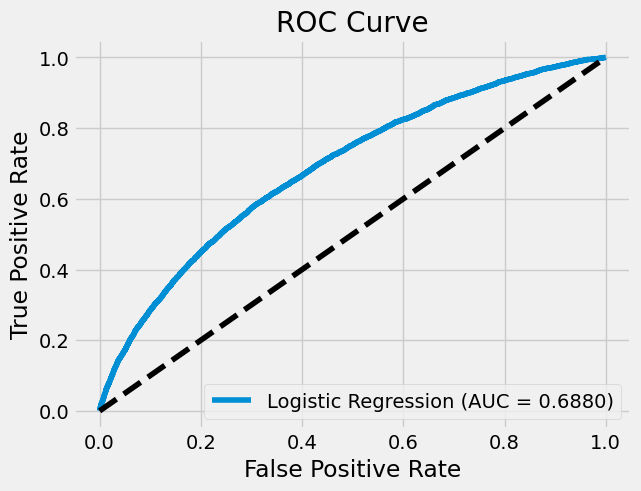


=== Random Forest ===


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.2s finished


Validation ROC AUC: 0.7383


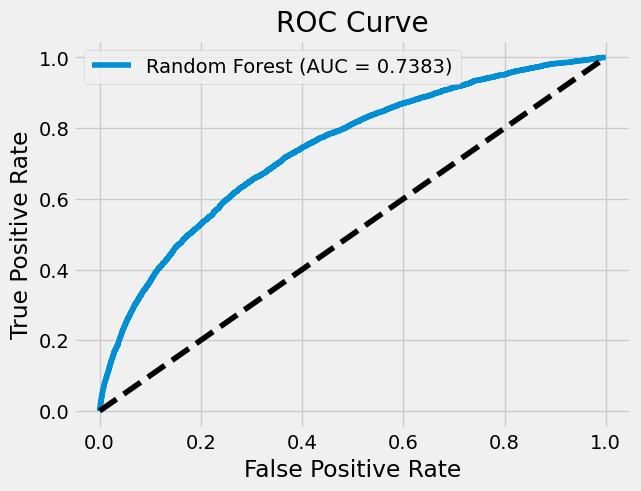

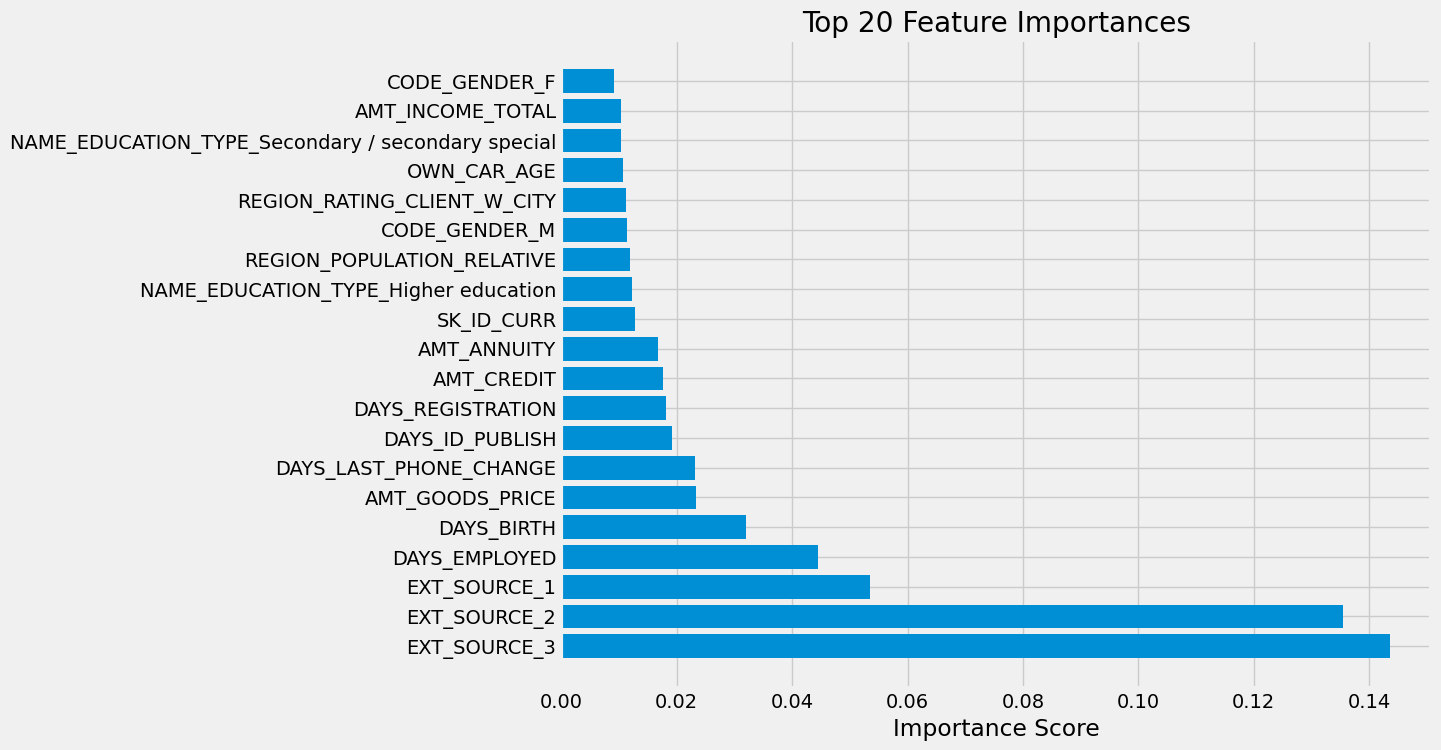

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Инициализация объектов
scaler = MinMaxScaler(feature_range=(0, 1))

if BaselineTraining:
    # Подготовка данных
    if 'TARGET' in app_train:
        train = app_train.drop(columns=['TARGET'])
    else:
        train = app_train.copy()
    
    test = app_test.copy()
    features = list(train.columns)
    
    # Обработка пропусков и масштабирование
    train = imputer.fit_transform(train)
    test = imputer.transform(test)
    
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    
    print('Training data shape:', train.shape)
    print('Testing data shape:', test.shape)
    
    # Функция для визуализации ROC-кривой
    def plot_roc_curve(y_true, y_proba, model_name):
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_true, y_proba):.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()
    
    if LogisticRegression:
        print("\n=== Logistic Regression ===")
        # Разделение данных
        X_train, X_valid, y_train, y_valid = train_test_split(
            train, train_labels, test_size=0.2, random_state=42, stratify=train_labels
        )
        
        # Обучение модели
        log_reg = LogisticRegression(
            C=0.0001,
            solver='lbfgs',
            max_iter=1000,
            random_state=42
        )
        log_reg.fit(X_train, y_train)
        
        # Оценка модели
        valid_pred = log_reg.predict_proba(X_valid)[:, 1]
        roc_auc = roc_auc_score(y_valid, valid_pred)
        print(f'Validation ROC AUC: {roc_auc:.4f}')
        
        # Визуализация ROC-кривой
        plot_roc_curve(y_valid, valid_pred, "Logistic Regression")
        
        # Прогноз на тестовых данных
        log_reg_pred = log_reg.predict_proba(test)[:, 1]
        
        # Сохранение результатов
        submit = app_test[['SK_ID_CURR']].copy()
        submit['TARGET'] = log_reg_pred
        submit.to_csv('log_reg_baseline.csv', index=False)
    
    if RandomForest:
        print("\n=== Random Forest ===")
        
        # Проверяем наличие TARGET перед удалением
        if 'TARGET' in app_train.columns:
            app_train = app_train.drop(columns='TARGET')
        
        # Преобразуем данные, обрабатываем пропуски и масштабируем
        features = list(app_train.columns)
        
        # Обработка пропусков
        train = imputer.fit_transform(app_train)
        test = imputer.transform(app_test)
        
        # Масштабирование данных
        train = scaler.fit_transform(train)
        test = scaler.transform(test)
        
        # Разделение данных на обучающие и валидационные
        X_train, X_valid, y_train, y_valid = train_test_split(
            train, train_labels, test_size=0.2, random_state=42, stratify=train_labels
        )
        
        # Обучение модели
        random_forest = RandomForestClassifier(
            n_estimators=100,
            max_depth=11,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        random_forest.fit(X_train, y_train)
        
        # Оценка модели
        valid_pred = random_forest.predict_proba(X_valid)[:, 1]
        roc_auc = roc_auc_score(y_valid, valid_pred)
        print(f'Validation ROC AUC: {roc_auc:.4f}')
        
        # Визуализация ROC-кривой
        plot_roc_curve(y_valid, valid_pred, "Random Forest")
        
        # Важность признаков
        feature_importances = pd.DataFrame({
            'feature': features,
            'importance': random_forest.feature_importances_
        }).sort_values('importance', ascending=False).head(20)
        
        plt.figure(figsize=(10, 8))
        plt.barh(feature_importances['feature'], feature_importances['importance'])
        plt.title('Top 20 Feature Importances')
        plt.xlabel('Importance Score')
        plt.show()
        
        # Прогноз на тестовых данных
        predictions = random_forest.predict_proba(test)[:, 1]
        
        # Сохранение результатов
        submit = app_test[['SK_ID_CURR']].copy()
        submit['TARGET'] = predictions
        submit.to_csv('random_forest_baseline.csv', index=False)


# Training (Engineered Features Implemented)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.6s finished


Random Forest (Polynomial Features) ROC AUC: 0.7144


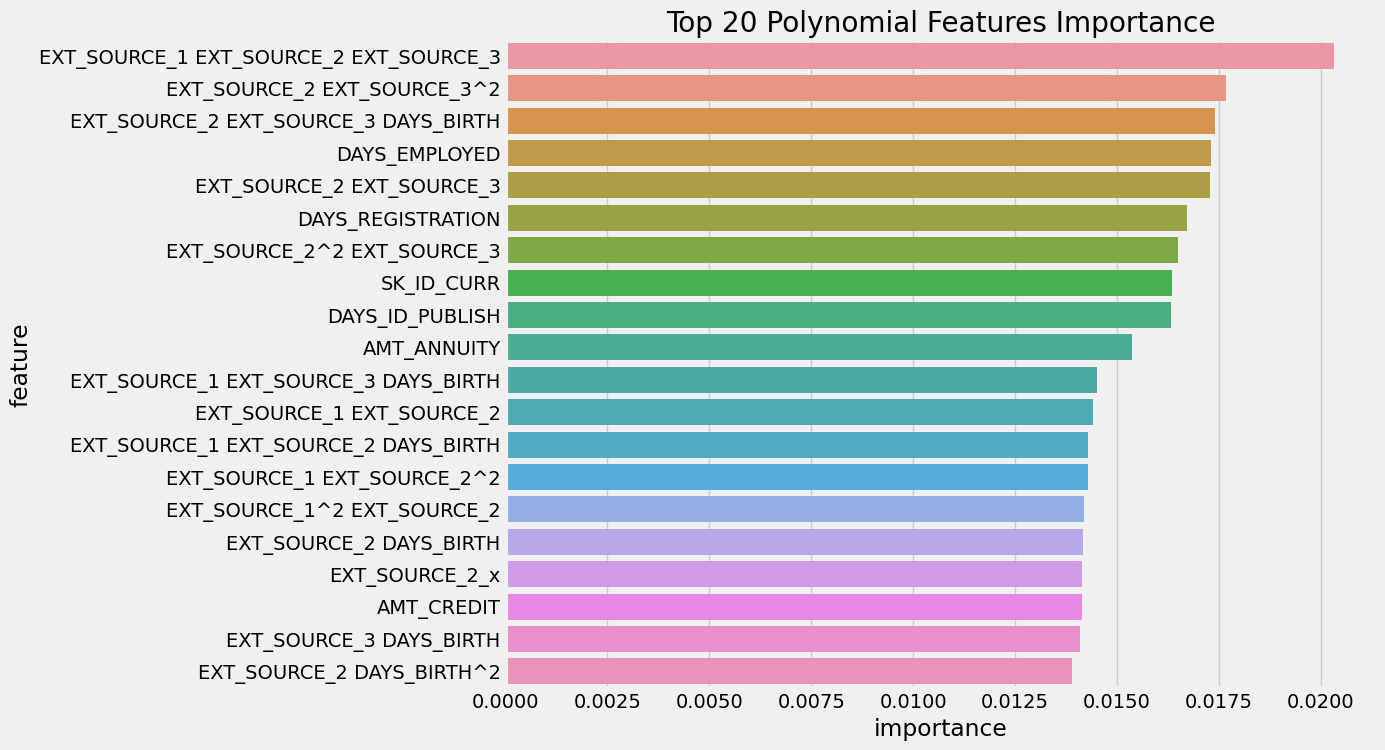

C:\Users\carka\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.6s finished


Random Forest (Domain Features) ROC AUC: 0.7116


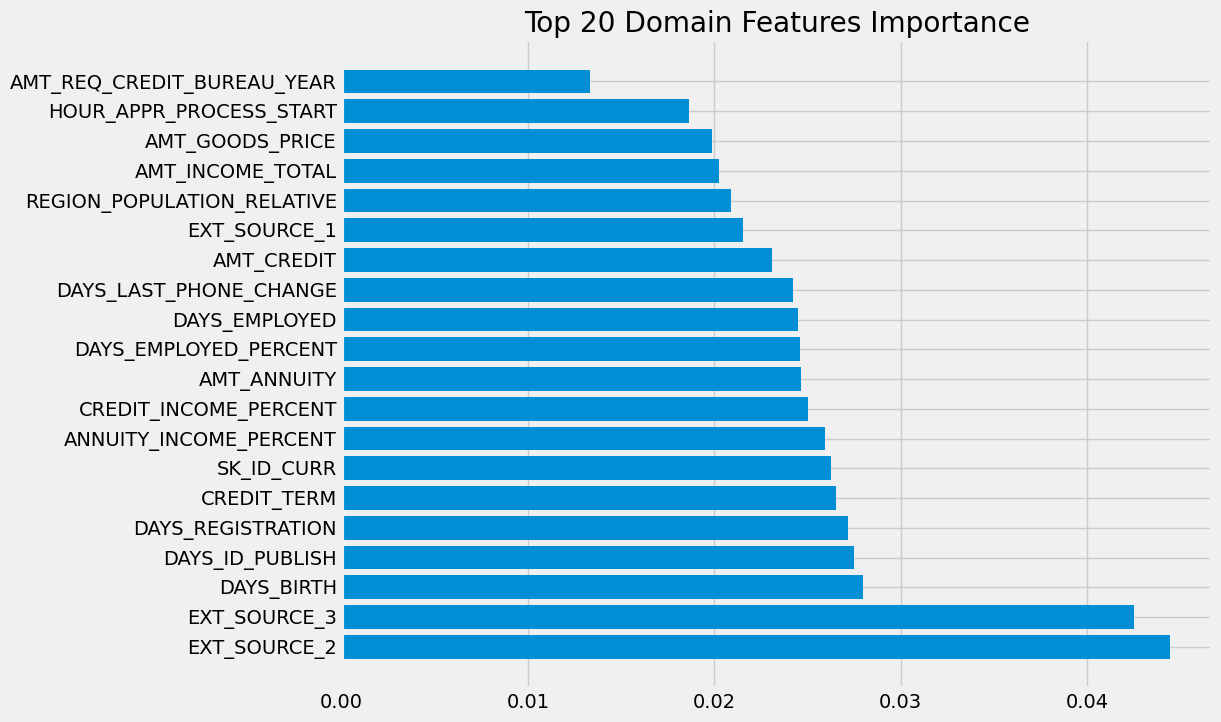

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.4s finished


In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

if PolynomialFeaturesTesting:
    poly_features_names = list(app_train_poly.columns)

    poly_features = imputer.fit_transform(app_train_poly)
    poly_features_test = imputer.transform(app_test_poly)

    poly_features = scaler.fit_transform(poly_features)
    poly_features_test = scaler.transform(poly_features_test)

    # Разделение данных
    X_train, X_valid, y_train, y_valid = train_test_split(
        app_train_poly, train_labels, test_size=0.2, random_state=42
    )

    # Обучение модели
    random_forest = RandomForestClassifier(
            n_estimators=100,
            max_depth=11,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
    random_forest_poly.fit(X_train, y_train)

    # Оценка модели
    valid_pred = random_forest_poly.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, valid_pred)
    print(f'Random Forest (Polynomial Features) ROC AUC: {roc_auc:.4f}')

    # Визуализация важности признаков
    feature_importances = pd.DataFrame({
        'feature': poly_features_names,
        'importance': random_forest_poly.feature_importances_
    }).sort_values('importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances)
    plt.title('Top 20 Polynomial Features Importance')
    plt.show()

    # Прогноз и сохранение
    predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]
    submit = app_test[['SK_ID_CURR']].copy()
    submit['TARGET'] = predictions
    submit.to_csv('random_forest_baseline_engineered.csv', index=False)

if DomainFeaturesTesting:
    # Проверяем наличие TARGET перед удалением
    if 'TARGET' in app_train_domain.columns:
        app_train_domain = app_train_domain.drop(columns='TARGET')
    
    domain_features_names = list(app_train_domain.columns)
    domain_features = imputer.fit_transform(app_train_domain)
    domain_features_test = imputer.transform(app_test_domain)

    domain_features = scaler.fit_transform(domain_features)
    domain_features_test = scaler.transform(domain_features_test)

    # Разделение данных
    X_train, X_valid, y_train, y_valid = train_test_split(
        domain_features, train_labels, test_size=0.2, random_state=42
    )

    # Обучение модели
    random_forest = RandomForestClassifier(
            n_estimators=100,
            max_depth=11,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
    random_forest_domain.fit(X_train, y_train)

    # Оценка модели
    valid_pred = random_forest_domain.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, valid_pred)
    print(f'Random Forest (Domain Features) ROC AUC: {roc_auc:.4f}')

    # Визуализация важности признаков
    feature_importances = pd.DataFrame({
        'feature': domain_features_names,
        'importance': random_forest_domain.feature_importances_
    }).sort_values('importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importances['feature'], feature_importances['importance'])
    plt.title('Top 20 Domain Features Importance')
    plt.show()

    # Прогноз и сохранение
    predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]
    submit = app_test[['SK_ID_CURR']].copy()
    submit['TARGET'] = predictions
    submit.to_csv('random_forest_baseline_domain.csv', index=False)

# Feature Importances (Example)

In [44]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

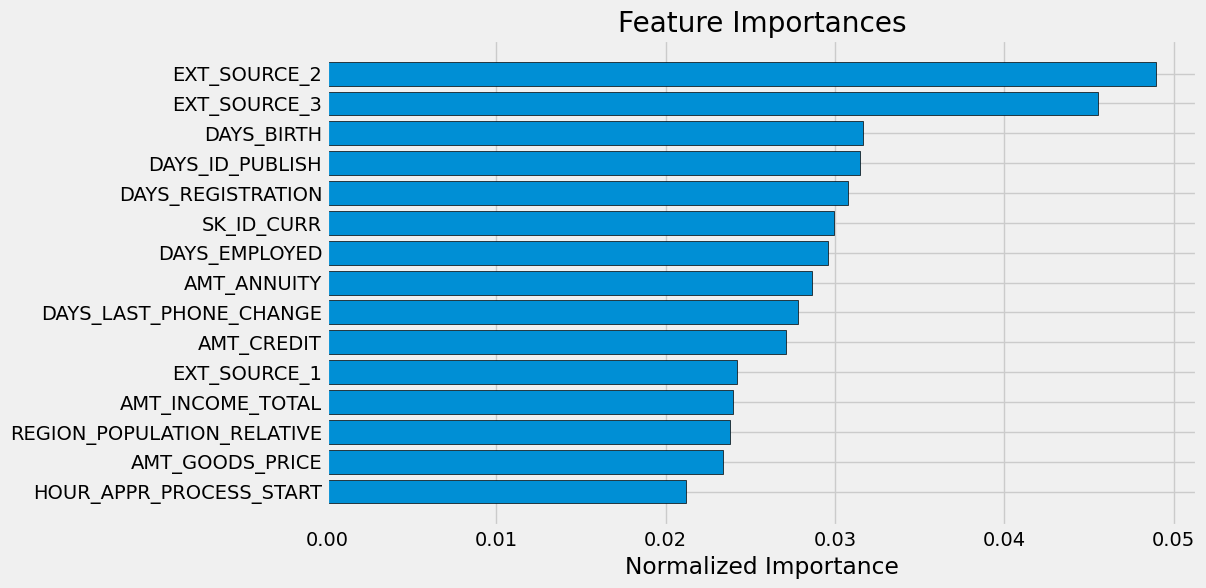

In [56]:
feature_importances_sorted = plot_feature_importances(feature_importances)

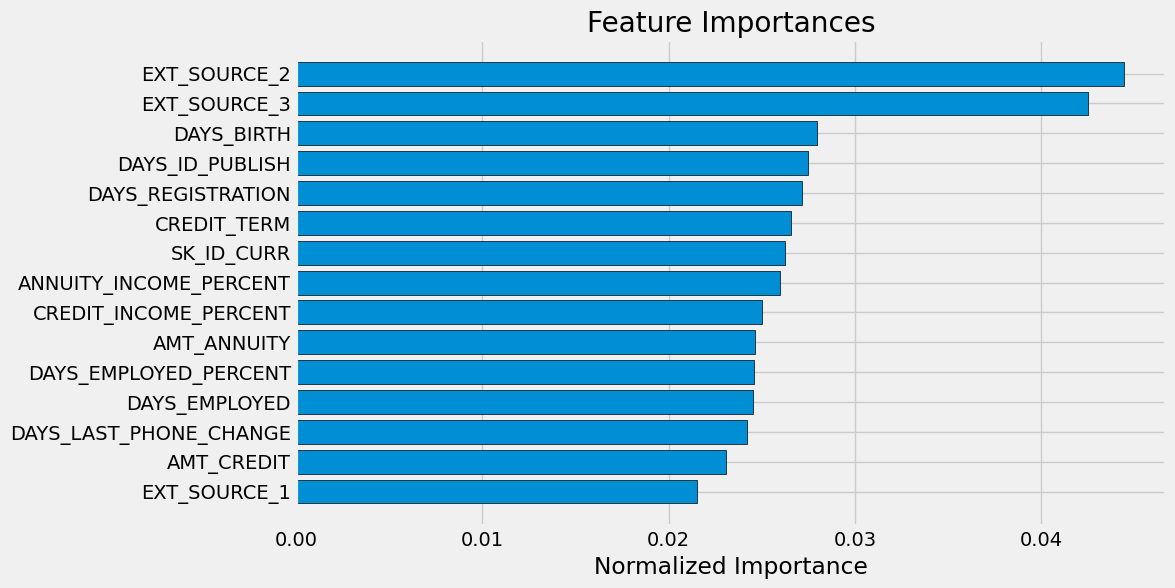

In [57]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

# Reload The Original Datasets For Final Training

In [39]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [40]:
def get_dataset():
    """
    load datasets
    1.app_train - train dataset 
    2.app_test - test datasets
    3.apps - concatenated app_train, app_test
    4.pos_bal - POS_CACHE
    5.install - installments_payments
    6.card_bal - Credit Card
    """
    app_train = pd.read_csv(os.path.join(default_dir,'application_train.csv'))
    app_train = reduce_mem_usage(app_train)
    app_test = pd.read_csv(os.path.join(default_dir,'application_test.csv'))
    app_test = reduce_mem_usage(app_test)
    apps = pd.concat([app_train, app_test])

    prev = pd.read_csv(os.path.join(default_dir,'previous_application.csv'))
    prev = reduce_mem_usage(prev)
    bureau = pd.read_csv(os.path.join(default_dir,'bureau.csv'))
    bureau = reduce_mem_usage(bureau)
    bureau_bal = pd.read_csv(os.path.join(default_dir,'bureau_balance.csv'))
    bureau_bal = reduce_mem_usage(bureau_bal)

    pos_bal, install, card_bal = get_balance_data()

    return apps, prev, bureau, bureau_bal, pos_bal, install, card_bal

apps, prev, bureau, bureau_bal, pos_bal, install, card_bal = get_dataset()

Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%


## Datasets Concatenation and Join

In [41]:
# apps prev_agg, bureau_agg, pos_bal_agg, install_agg, card_bal_agg
def get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal):
    """
    Description :
    1.Data preparation , aggregation 
    2.produce the finalized result
    """
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    bureau_agg = get_bureau_agg(bureau, bureau_bal)
    pos_bal_agg = get_pos_bal_agg(pos_bal)
    install_agg = get_install_agg(install)
    card_bal_agg = get_card_bal_agg(card_bal)
    print('prev_agg shape:', prev_agg.shape, 'bureau_agg shape:', bureau_agg.shape )
    print('pos_bal_agg shape:', pos_bal_agg.shape, 'install_agg shape:', install_agg.shape, 'card_bal_agg shape:', card_bal_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)

    # Join with apps_all
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(bureau_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(pos_bal_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(install_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(card_bal_agg, on='SK_ID_CURR', how='left')

    print('apps_all after merge with all shape:', apps_all.shape)

    return apps_all

In [42]:
def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

## NN


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset

from roc_auc import plot_roc_curve

C:\Users\carka\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [45]:
target_column = 'TARGET'

In [ ]:
###################test

In [47]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset

# Подготовка данных
train = apps_all[~apps_all['TARGET'].isnull()]
test = apps_all[apps_all['TARGET'].isnull()].drop('TARGET', axis=1)

X = train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = train['TARGET']

# Обработка бесконечных значений
X = X.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

# Заполнение пропущенных значений
X = X.fillna(X.median())
test = test.fillna(test.median())

# Обработка пропусков с помощью SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Использование взвешенных потерь для борьбы с несбалансированными классами
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(torch.device("cpu"))

# Нейросетевая модель
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 400)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        self.prelu1 = nn.PReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(400, 160)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        self.prelu2 = nn.PReLU()
        self.bn2 = nn.BatchNorm1d(160)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(160, 64)
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        self.prelu3 = nn.PReLU()
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(64, 26)
        nn.init.kaiming_normal_(self.fc4.weight, nonlinearity='relu')
        self.prelu4 = nn.PReLU()
        self.bn4 = nn.BatchNorm1d(26)
        self.dropout4 = nn.Dropout(0.3)

        self.fc5 = nn.Linear(26, 12)
        nn.init.kaiming_normal_(self.fc5.weight, nonlinearity='relu')
        self.prelu5 = nn.PReLU()
        self.bn5 = nn.BatchNorm1d(12)
        self.dropout5 = nn.Dropout(0.3)

        self.fc6 = nn.Linear(12, 1)

    def forward(self, x):
        x = self.dropout1(self.prelu1(self.fc1(x)))
        x = self.dropout2(self.bn2(self.prelu2(self.fc2(x))))
        x = self.dropout3(self.bn3(self.prelu3(self.fc3(x))))
        x = self.dropout4(self.bn4(self.prelu4(self.fc4(x))))
        x = self.dropout5(self.bn5(self.prelu5(self.fc5(x))))
        x = torch.sigmoid(self.fc6(x))  # Сигмоида для бинарной классификации
        return x

# Создание DataLoader
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)  # Приведение к numpy массиву
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)  # Приведение к numpy массиву

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Инициализация модели, функции потерь и оптимизатора
model = SimpleNN()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device is {device}")
model.to(device)

criterion = nn.BCELoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Раннее остановка (Early Stopping)
early_stopping_patience = 5
best_loss = float('inf')
patience_counter = 0

# Обучение модели
num_epochs = 30
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

    # Раннее остановка
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered!")
            break

# Оценка модели
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor)
    y_pred = (y_pred_prob > 0.5).float()

# Вывод значений потерь и ROC AUC
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.4f}")


Device is cpu


RuntimeError: output with shape [512, 1] doesn't match the broadcast shape [512, 2]

In [48]:

# Подготовка данных
train = apps_all[~apps_all['TARGET'].isnull()]
test = apps_all[apps_all['TARGET'].isnull()].drop('TARGET', axis=1)

X = train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = train['TARGET']

# Обработка бесконечных значений
X = X.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

# Заполнение пропущенных значений
X = X.fillna(X.median())
test = test.fillna(test.median())

# Обработка пропусков с помощью SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [56]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 400)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        self.prelu1 = nn.PReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(400, 160)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        self.prelu2 = nn.PReLU()
        self.bn2 = nn.BatchNorm1d(160)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(160, 64)
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        self.prelu3 = nn.PReLU()
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(64, 26)
        nn.init.kaiming_normal_(self.fc4.weight, nonlinearity='relu')
        self.prelu4 = nn.PReLU()
        self.bn4 = nn.BatchNorm1d(26)
        self.dropout4 = nn.Dropout(0.3)

        self.fc5 = nn.Linear(26, 12)
        nn.init.kaiming_normal_(self.fc5.weight, nonlinearity='relu')
        self.prelu5 = nn.PReLU()
        self.bn5 = nn.BatchNorm1d(12)
        self.dropout5 = nn.Dropout(0.3)

        self.fc6 = nn.Linear(12, 1)

    def forward(self, x):
        x = self.dropout1(self.prelu1(self.fc1(x)))
        x = self.dropout2(self.bn2(self.prelu2(self.fc2(x))))
        x = self.dropout3(self.bn3(self.prelu3(self.fc3(x))))
        x = self.dropout4(self.bn4(self.prelu4(self.fc4(x))))
        x = self.dropout5(self.bn5(self.prelu5(self.fc5(x))))
        x = torch.sigmoid(self.fc6(x))
        return x


Divice is cpu
Epoch [1/50], Loss: 0.3483
Epoch [2/50], Loss: 0.2569
Epoch [3/50], Loss: 0.2514
Epoch [4/50], Loss: 0.2485
Epoch [5/50], Loss: 0.2470
Epoch [6/50], Loss: 0.2441
Epoch [7/50], Loss: 0.2421
Epoch [8/50], Loss: 0.2400
Epoch [9/50], Loss: 0.2377
Epoch [10/50], Loss: 0.2359
Epoch [11/50], Loss: 0.2345
Epoch [12/50], Loss: 0.2325
Epoch [13/50], Loss: 0.2308
Epoch [14/50], Loss: 0.2290
Epoch [15/50], Loss: 0.2274
Epoch [16/50], Loss: 0.2255
Epoch [17/50], Loss: 0.2244
Epoch [18/50], Loss: 0.2235
Epoch [19/50], Loss: 0.2222
Epoch [20/50], Loss: 0.2210
Epoch [21/50], Loss: 0.2201
Epoch [22/50], Loss: 0.2189
Epoch [23/50], Loss: 0.2169
Epoch [24/50], Loss: 0.2169
Epoch [25/50], Loss: 0.2168
Epoch [26/50], Loss: 0.2155
Epoch [27/50], Loss: 0.2149
Epoch [28/50], Loss: 0.2134
Epoch [29/50], Loss: 0.2134
Epoch [30/50], Loss: 0.2125
Epoch [31/50], Loss: 0.2113
Epoch [32/50], Loss: 0.2111
Epoch [33/50], Loss: 0.2091
Epoch [34/50], Loss: 0.2098
Epoch [35/50], Loss: 0.2086
Epoch [36/50], 

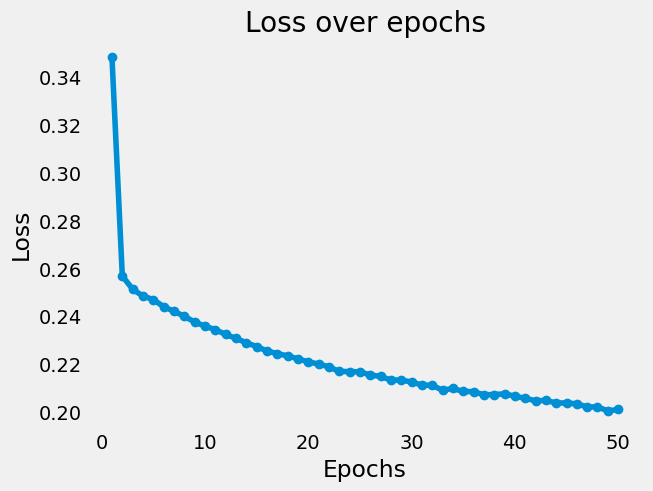

In [49]:
# Создание DataLoader
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)  # Приведение к numpy массиву
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)  # Приведение к numpy массиву

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Инициализация модели, функции потерь и оптимизатора
model = SimpleNN()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Divice is {device}")
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# Увеличиваем количество эпох
num_epochs = 50  

# Добавляем раннюю остановку
patience = 10
best_loss = float('inf')
patience_counter = 0

# Обучение модели с ранней остановкой
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

    # Ранняя остановка
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Оценка модели
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor)
    y_pred = (y_pred_prob > 0.5).float()

# ROC AUC
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.4f}")


# Вывод значений потерь
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [60]:
from sklearn.metrics import roc_auc_score

# Предсказания для тестового набора данных (предположим, что y_pred уже бинарные)
# Это вероятности для класса 1
y_pred_prob = model(X_test_tensor).detach().cpu().numpy()

# Для ROC AUC нам нужны вероятности, а не бинарные метки
auc = roc_auc_score(y_test, y_pred_prob)

print(f"ROC AUC: {auc:.4f}")


ROC AUC: 0.7550


In [54]:
from sklearn.metrics import roc_auc_score
import numpy as np

def calculate_feature_importance(model, X, y, metric=roc_auc_score, num_repeats=5):
    model.eval()
    baseline_preds = model(torch.FloatTensor(X)).detach().numpy()
    baseline_score = metric(y, baseline_preds)

    importances = []

    for i in range(X.shape[1]):
        scores = []
        for _ in range(num_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, i])  # перемешиваем i-й столбец
            preds = model(torch.FloatTensor(X_permuted)).detach().numpy()
            score = metric(y, preds)
            scores.append(score)
        importance = baseline_score - np.mean(scores)
        importances.append(importance)

    return np.array(importances)


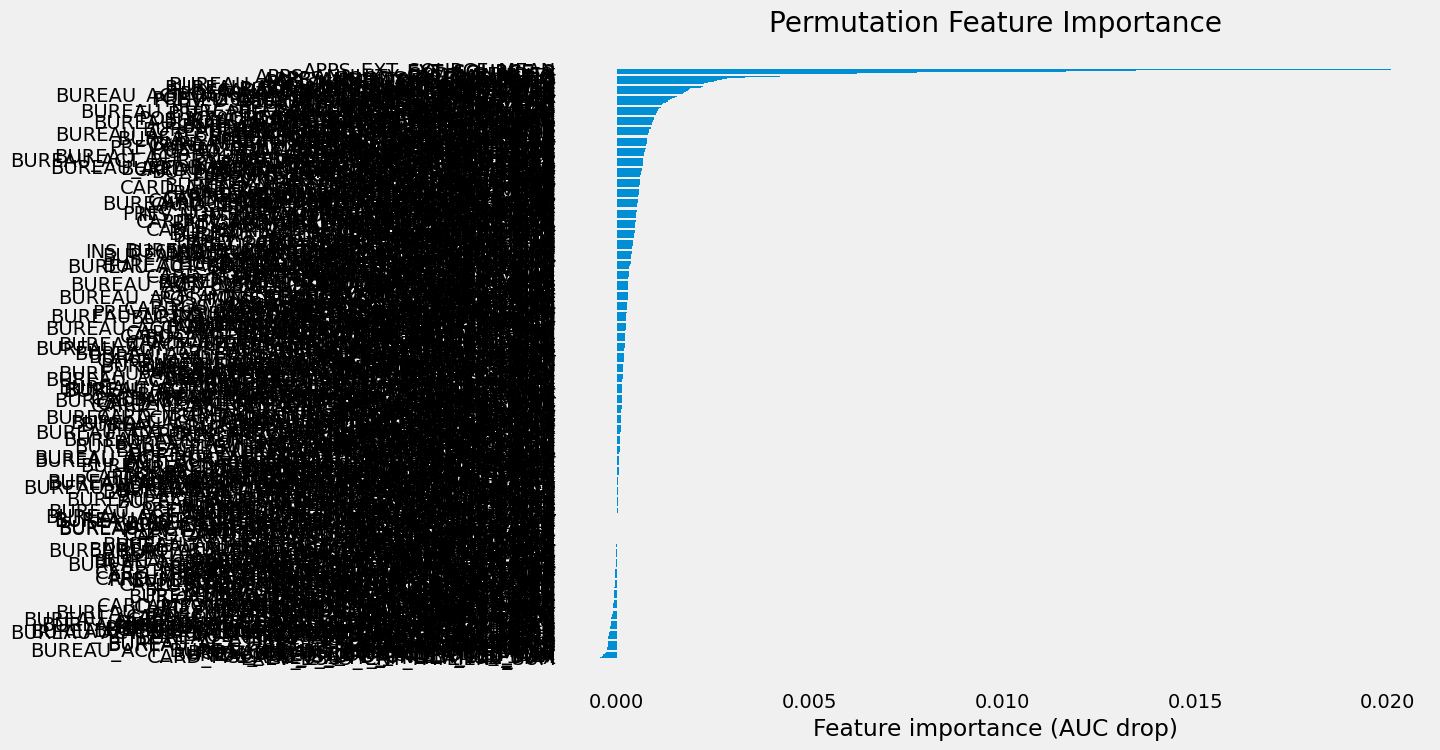

In [55]:
# Преобразуем X_test_tensor в numpy
X_test_np = X_test_tensor.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

importances = calculate_feature_importance(model, X_test_np, y_test_np)

# Визуализация
import matplotlib.pyplot as plt

feature_names = X.columns  # если сохранили колонки
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances[sorted_idx])
plt.yticks(range(len(importances)), feature_names[sorted_idx])
plt.xlabel("Feature importance (AUC drop)")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()
plt.grid()
plt.show()


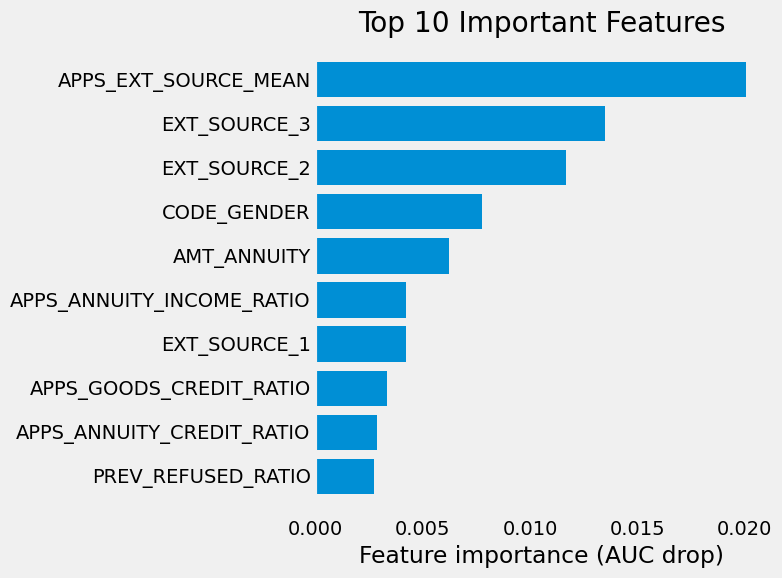

In [57]:
top_indices = np.argsort(importances)[::-1][:10]
top_features = [feature_names[i] for i in top_indices]
top_importances = [importances[i] for i in top_indices]

plt.figure(figsize=(8, 6))
plt.barh(range(10), top_importances[::-1])
plt.yticks(range(10), top_features[::-1])
plt.xlabel("Feature importance (AUC drop)")
plt.title("Top 10 Important Features")
plt.grid()
plt.tight_layout()
plt.show()


# Final Training (LGBM)

In [127]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]
    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    return apps_all_train, apps_all_test

def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(
        ftr_app, 
        target_app, 
        test_size=0.2, 
        random_state=2020,
        stratify=target_app  # Добавлено стратифицированное разбиение
    )
    
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=2000,
        learning_rate=0.02,
        max_depth=11,
        num_leaves=58,
        colsample_bytree=0.613,
        subsample=0.708,
        max_bin=407,
        reg_alpha=3.564,
        reg_lambda=4.930,
        min_child_weight=6,
        min_child_samples=165,
        silent=True,
        verbose=-1,
    )
   
    clf.fit(
        train_x, 
        train_y,
        eval_set=[(train_x, train_y), (valid_x, valid_y)],
        eval_metric='auc',
        callbacks=[
            early_stopping(stopping_rounds=200),
            log_evaluation(100)  # Вывод лога каждые 100 итераций
        ]
    )
    
    return clf

In [43]:
# application, previous, bureau, bureau_bal
apps_all = get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal)
del apps,prev,bureau,bureau_bal,pos_bal,install,card_bal
gc.collect()

# Category Label
apps_all = get_apps_all_encoded(apps_all)

apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)

clf = train_apps_all(apps_all_train)

C:\Users\carka\AppData\Local\Temp\ipykernel_17976\1438099645.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
C:\Users\carka\AppData\Local\Temp\ipykernel_17976\1438099645.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
C:\Users\carka\anaconda3\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in

prev_agg shape: (338857, 80) bureau_agg shape: (305811, 149)
pos_bal_agg shape: (337252, 45) install_agg shape: (339587, 59) card_bal_agg shape: (103558, 70)
apps_all before merge shape: (356255, 135)
apps_all after merge with all shape: (356255, 534)


NameError: name 'get_apps_all_train_test' is not defined

In [143]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]
    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    return apps_all_train, apps_all_test

def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(
        ftr_app, 
        target_app, 
        test_size=0.2, 
        random_state=2020,
        stratify=target_app
    )
    
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    
    # Определяем категориальные признаки (если есть)
    cat_features = list(ftr_app.select_dtypes(include=['object', 'category']).columns)
    
    clf = CatBoostClassifier(
        iterations=2000,
        learning_rate=0.02,
        depth=11,  # Используем depth вместо max_leaves
        l2_leaf_reg=3.564,
        border_count=254,
        random_strength=1.0,
        bagging_temperature=1.0,
        od_type='Iter',
        od_wait=100,
        thread_count=-1,
        random_seed=42,
        loss_function='Logloss',
        eval_metric='AUC',
        use_best_model=True,
        verbose=100
    )
    
    train_pool = Pool(train_x, train_y, cat_features=cat_features)
    valid_pool = Pool(valid_x, valid_y, cat_features=cat_features)
    
    clf.fit(
        train_pool,
        eval_set=valid_pool,
        early_stopping_rounds=200,
        plot=True
    )
    
    return clf

# Загрузка и подготовка данных
apps_all = get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal)
del apps, prev, bureau, bureau_bal, pos_bal, install, card_bal
gc.collect()

# Кодирование категориальных переменных
apps_all = get_apps_all_encoded(apps_all)

# Разделение на train/test
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)

# Обучение модели
clf = train_apps_all(apps_all_train)

# Прогнозирование
test_pool = Pool(apps_all_test.drop(['SK_ID_CURR'], axis=1))
predictions = clf.predict_proba(test_pool)[:, 1]

# Сохранение результатов
submit = apps_all_test[['SK_ID_CURR']].copy()
submit['TARGET'] = predictions
submit.to_csv('catboost_submission.csv', index=False)

C:\Users\carka\AppData\Local\Temp\ipykernel_15508\1438099645.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
C:\Users\carka\AppData\Local\Temp\ipykernel_15508\1438099645.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
C:\Users\carka\anaconda3\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in

prev_agg shape: (338857, 80) bureau_agg shape: (305811, 149)
pos_bal_agg shape: (337252, 45) install_agg shape: (339587, 59) card_bal_agg shape: (103558, 70)
apps_all before merge shape: (356255, 135)
apps_all after merge with all shape: (356255, 534)
train shape: (246008, 532) valid shape: (61503, 532)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7061235	best: 0.7061235 (0)	total: 2.4s	remaining: 1h 20m 6s
100:	test: 0.7668982	best: 0.7668982 (100)	total: 4m 41s	remaining: 1h 28m 20s
200:	test: 0.7775936	best: 0.7775936 (200)	total: 9m 43s	remaining: 1h 27m 4s


KeyboardInterrupt: 

In [60]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import gc

# Подготовка данных
train = apps_all[~apps_all['TARGET'].isnull()]
test = apps_all[apps_all['TARGET'].isnull()].drop('TARGET', axis=1)

X = train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = train['TARGET']

# Быстрое обучение с оптимальными параметрами
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    random_seed=42,
    thread_count=-1,
    verbose=50,
    early_stopping_rounds=50,
    eval_metric='AUC'
)

# Обучение с валидацией
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

# Прогнозирование и сохранение
test[['SK_ID_CURR']].assign(TARGET=model.predict_proba(test.drop('SK_ID_CURR', axis=1))[:, 1])\
   .to_csv('catboost_fast_submission.csv', index=False)


gc.collect()

0:	test: 0.6972633	best: 0.6972633 (0)	total: 470ms	remaining: 3m 54s
50:	test: 0.7677910	best: 0.7677910 (50)	total: 19.4s	remaining: 2m 50s
100:	test: 0.7776162	best: 0.7776162 (100)	total: 38.1s	remaining: 2m 30s
150:	test: 0.7824929	best: 0.7824929 (150)	total: 55.8s	remaining: 2m 8s
200:	test: 0.7852305	best: 0.7852305 (200)	total: 1m 12s	remaining: 1m 48s
250:	test: 0.7870768	best: 0.7870768 (250)	total: 1m 31s	remaining: 1m 31s
300:	test: 0.7888928	best: 0.7888928 (300)	total: 1m 48s	remaining: 1m 11s
350:	test: 0.7899242	best: 0.7899299 (349)	total: 2m 5s	remaining: 53.4s
400:	test: 0.7905535	best: 0.7905601 (399)	total: 2m 21s	remaining: 34.9s
450:	test: 0.7910456	best: 0.7910699 (441)	total: 2m 36s	remaining: 17s
499:	test: 0.7916818	best: 0.7916818 (499)	total: 2m 51s	remaining: 0us

bestTest = 0.7916818136
bestIteration = 499



369

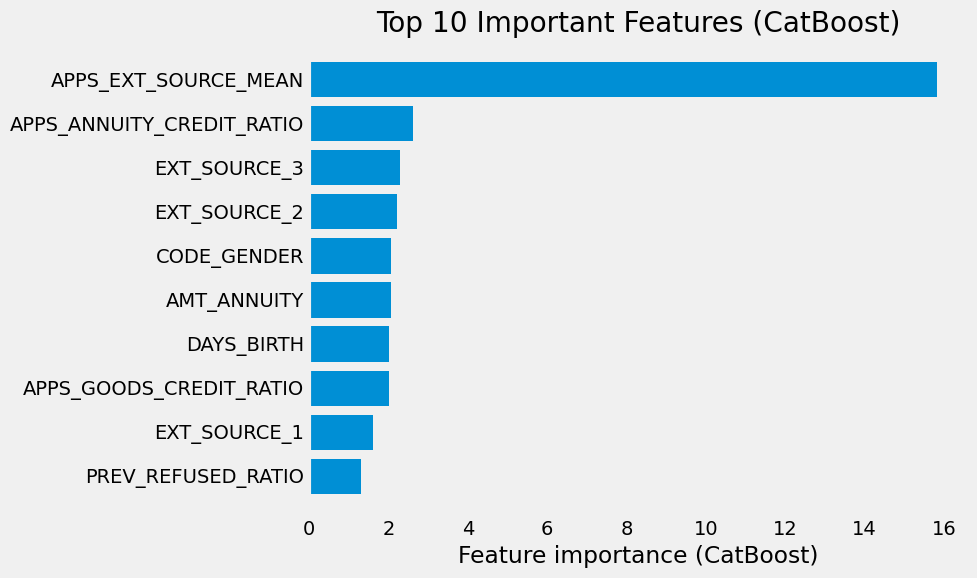

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Получаем важности
importances = model.get_feature_importance()
feature_names = X.columns  # X у тебя уже есть до удаления, иначе загрузи заново

# Топ-10
top_indices = np.argsort(importances)[::-1][:10]
top_features = [feature_names[i] for i in top_indices]
top_importances = [importances[i] for i in top_indices]

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(range(10), top_importances[::-1])
plt.yticks(range(10), top_features[::-1])
plt.xlabel("Feature importance (CatBoost)")
plt.title("Top 10 Important Features (CatBoost)")
plt.grid()
plt.tight_layout()
plt.show()


In [146]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import gc

# Подготовка данных
train = apps_all[~apps_all['TARGET'].isnull()]
test = apps_all[apps_all['TARGET'].isnull()].drop('TARGET', axis=1)

X = train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = train['TARGET']

# Обработка бесконечных значений
X = X.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

# Заполнение пропущенных значений
X = X.fillna(X.median())
test = test.fillna(test.median())

# Быстрое обучение с оптимальными параметрами
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc',
    early_stopping_rounds=50,
    tree_method='hist',
    missing=np.nan  # Явное указание на пропущенные значения
)

# Разделение данных и обучение
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=50
)

# Прогнозирование и сохранение результатов
test['TARGET'] = model.predict_proba(test.drop('SK_ID_CURR', axis=1))[:, 1]
test[['SK_ID_CURR', 'TARGET']].to_csv('xgboost_fast_submission.csv', index=False)

# Очистка памяти
del train, test, X, y, X_train, X_valid, y_train, y_valid
gc.collect()

[0]	validation_0-auc:0.72829
[50]	validation_0-auc:0.76811
[100]	validation_0-auc:0.78194
[150]	validation_0-auc:0.78742
[200]	validation_0-auc:0.79006
[250]	validation_0-auc:0.79204
[299]	validation_0-auc:0.79317


C:\Users\carka\AppData\Local\Temp\ipykernel_15508\3038651513.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['TARGET'] = model.predict_proba(test.drop('SK_ID_CURR', axis=1))[:, 1]


34743

# Prediction

In [ ]:
apps_all_test

In [50]:
output_dir = "../output/kaggle/working/"
preds = clf.predict_proba(apps_all_test.drop(['SK_ID_CURR'], axis=1))[:, 1]
apps_all_test['TARGET'] = preds
#apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(output_dir,'pos_install_credit_02.csv'), index=False)
apps_all_test[['SK_ID_CURR', 'TARGET']]

,SK_ID_CURR,TARGET
307511,100001,0.037444
307512,100005,0.160327
307513,100013,0.055151
307514,100028,0.038324
307515,100038,0.220887
...,...,...
356250,456221,0.026671
356251,456222,0.040213
356252,456223,0.009467
356253,456224,0.021586


In [51]:
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv('submission.csv', index=False)

# Feature Importances (Final)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

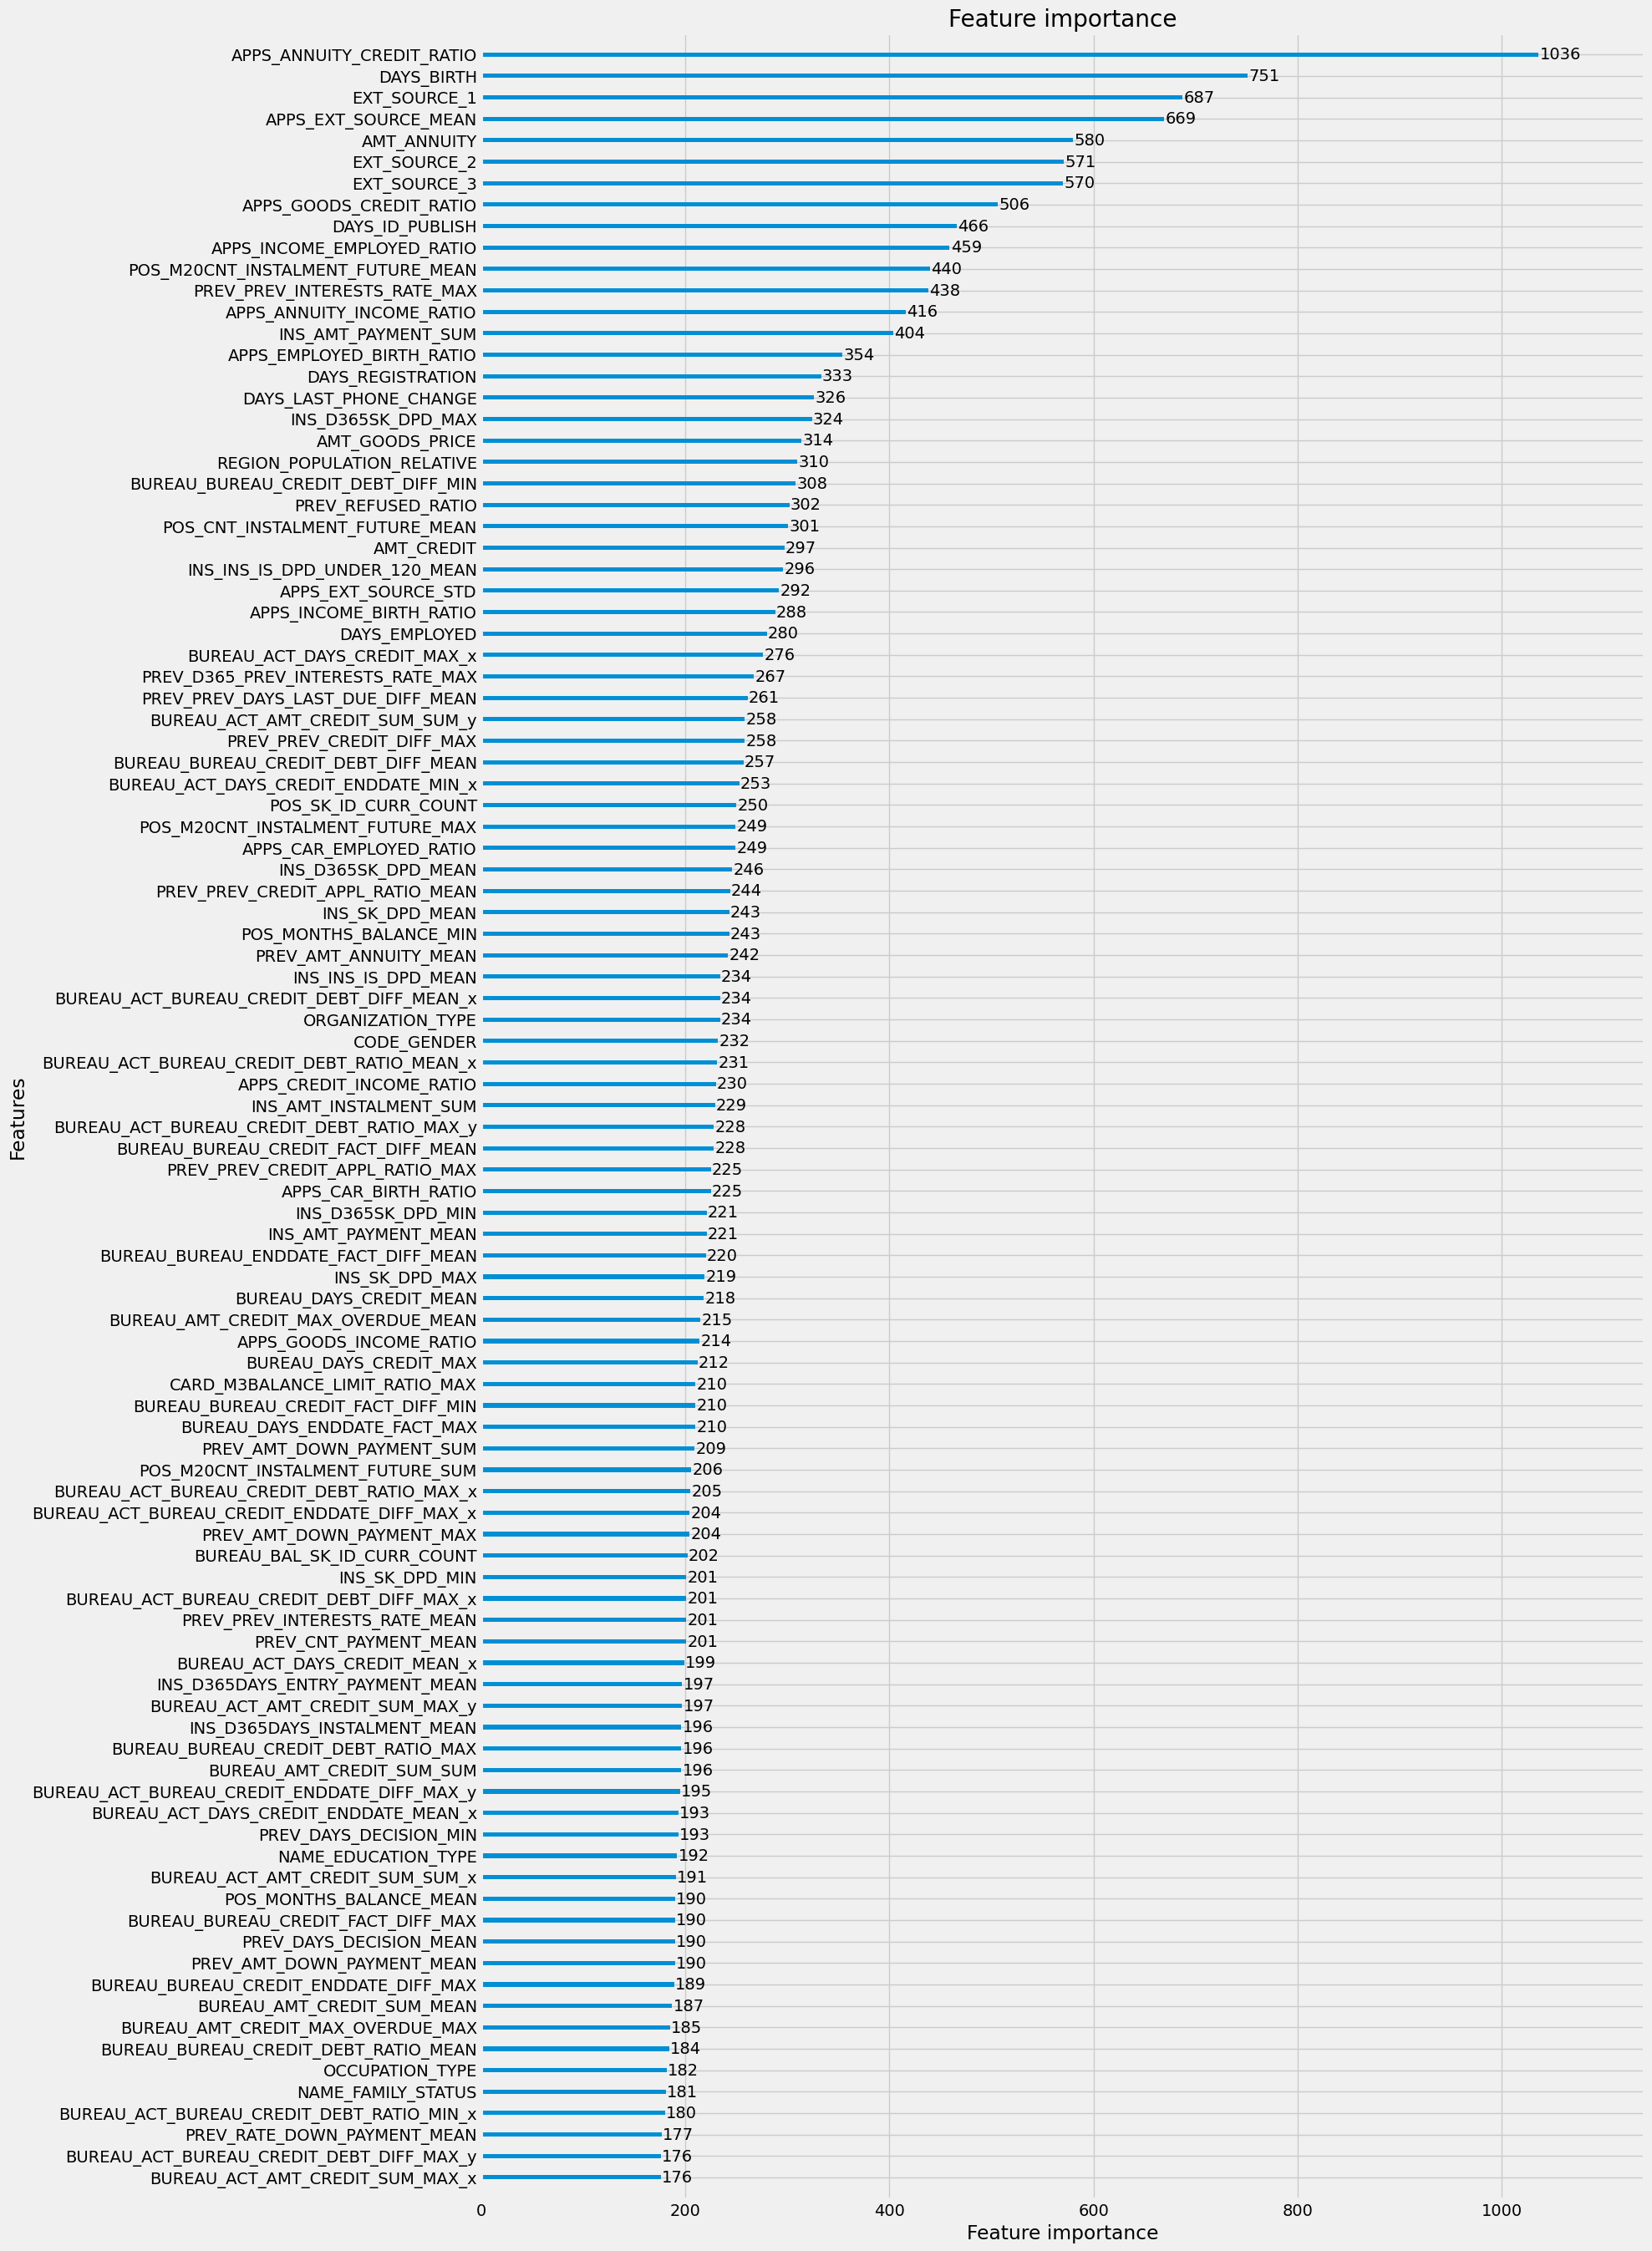

In [147]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32), max_num_features=100)

Text(0.5, 1.0, 'Domain Knowledge Features Correlation Heatmap')

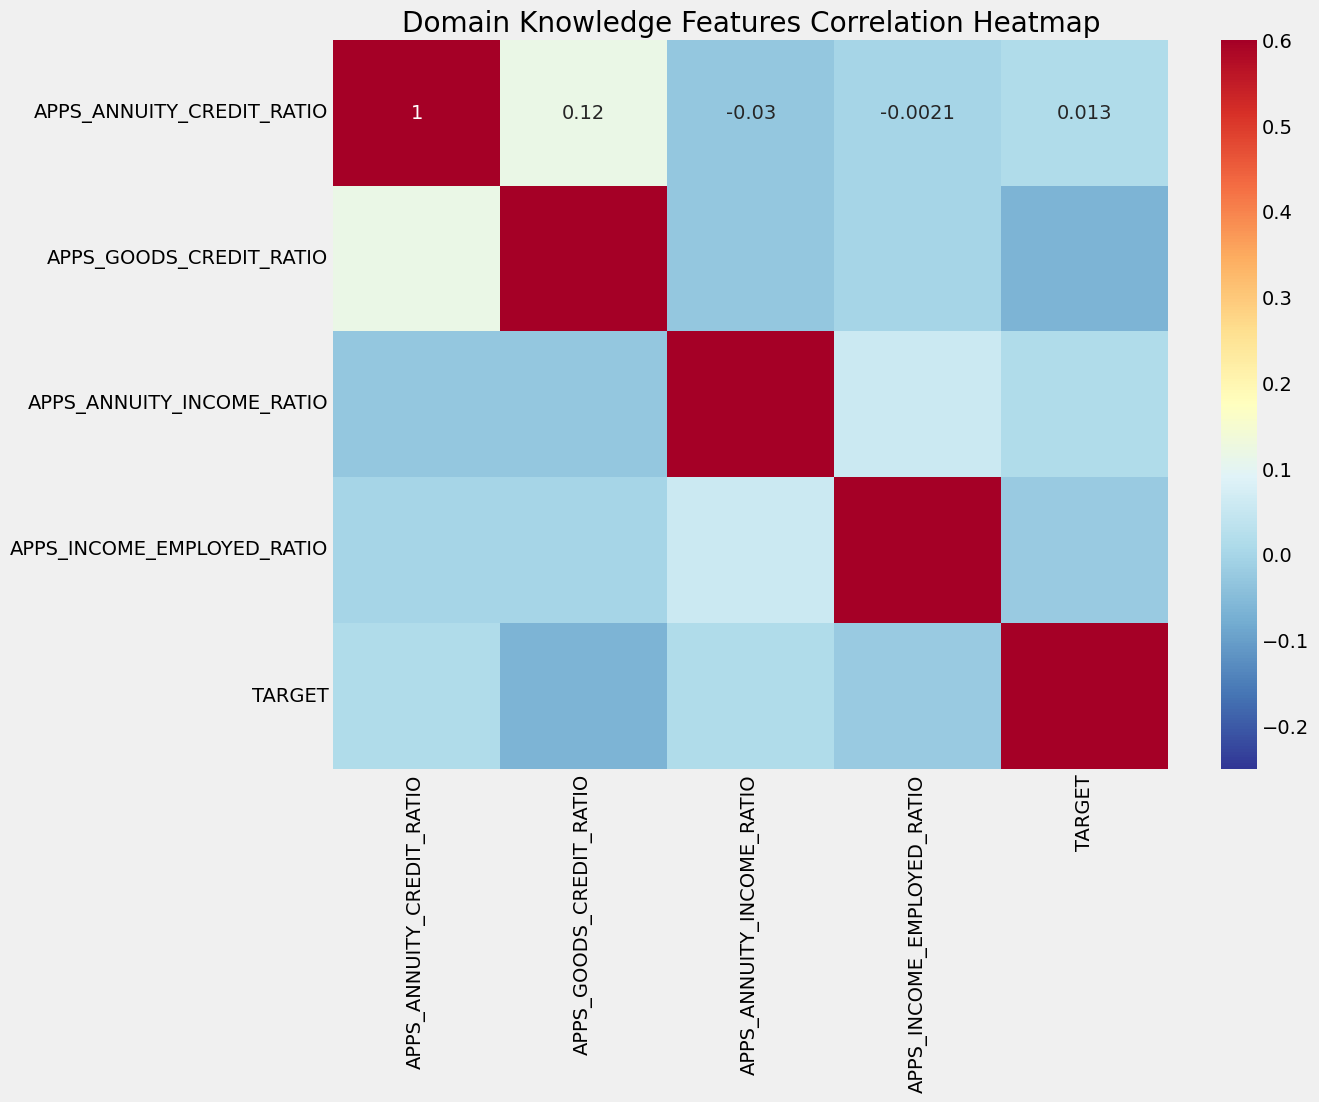

In [148]:
# https://stackoverflow.com/questions/42579908/use-corr-to-get-the-correlation-between-two-columns
Domain_Knowledge_Features_corrs = apps_all_train[['APPS_ANNUITY_CREDIT_RATIO', 'APPS_GOODS_CREDIT_RATIO', 'APPS_ANNUITY_INCOME_RATIO', 'APPS_INCOME_EMPLOYED_RATIO', 'TARGET']].corr()

plt.figure(figsize = (12, 9))

# Heatmap of correlations
sns.heatmap(Domain_Knowledge_Features_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Domain Knowledge Features Correlation Heatmap')

# plt.savefig('./Domain Knowledge Features Correlation Heatmap.png', bbox_inches = 'tight')
# plt.imshow(plt.imread('./Domain Knowledge Features Correlation Heatmap.png'))